# Capacity allocation

## 0. Load libraries

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from benchmarks.generator import get_revenue_behaviour, get_revenue_behaviour_deprecated
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, infer_line_stations, get_services_by_tsp_df, plot_marey_chart
from src.entities import GSA, Solution

from robin.scraping.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from pathlib import Path
from typing import Any, List, Mapping, Tuple, Union
import shutil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/gsa_results/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

if Path(robin_save_path).exists():
    shutil.rmtree(robin_save_path)
    
Path(robin_save_path).mkdir(parents=True)

if Path(figures).exists():
    shutil.rmtree(figures)

Path(figures).mkdir(parents=True)

In [6]:
seed = 21

if generator_config_path:
    n_services = int_input("Number of services to generate: ")
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(file_name=generator_save_path,
                           path_config=generator_config_path,
                           n_services=n_services,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 25


In [7]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)

print(tsp_df)

       Number of Services
RU2                     4
RU3                    10
RU1                     6
RU4                     5
Total                  25


In [8]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behaviour = get_revenue_behaviour_deprecated(supply)
lines = supply.lines
line = infer_line_stations(lines)

Services:  25


/Users/david/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


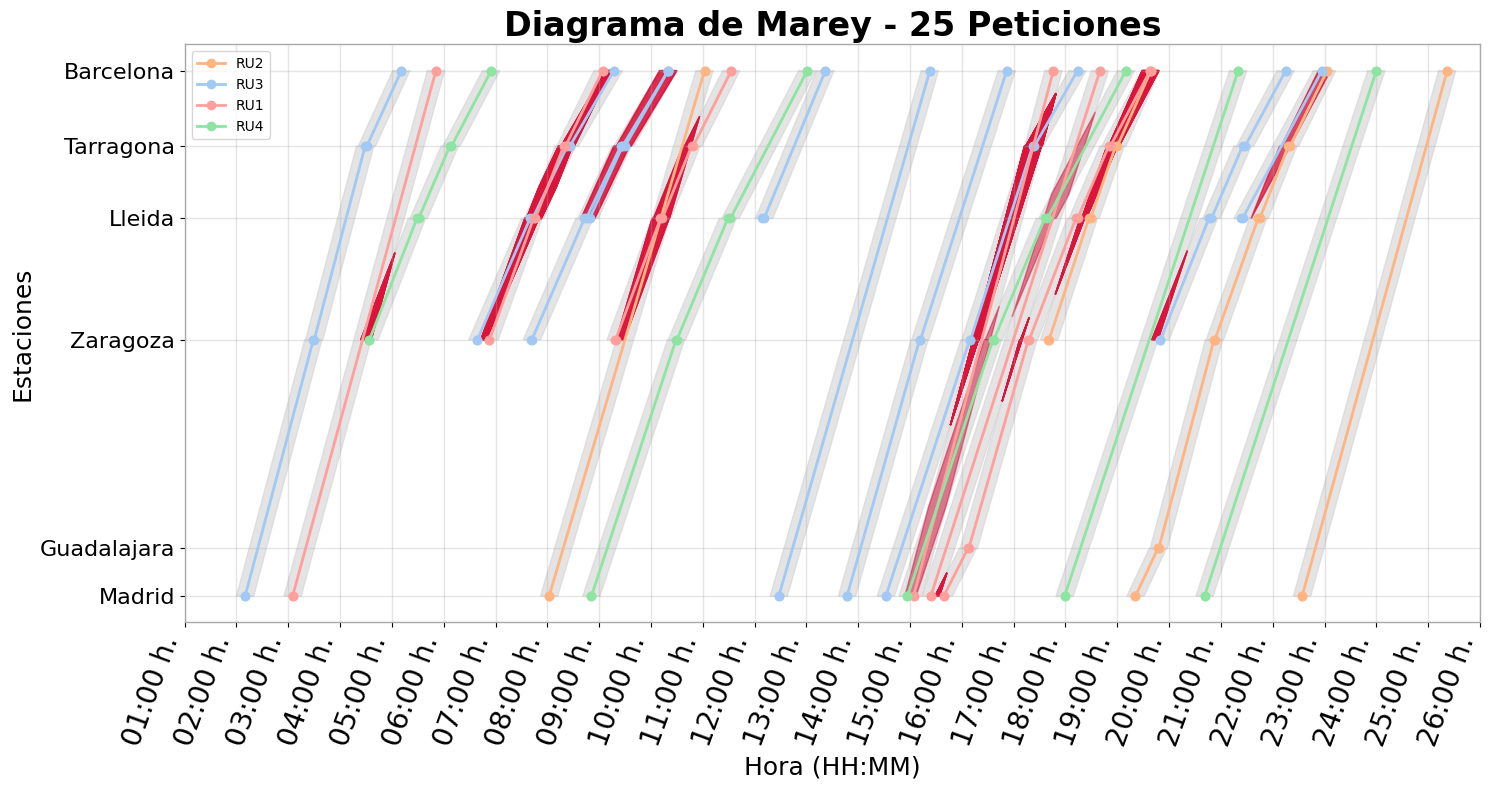

In [9]:
plot_marey_chart(requested_supply=supply,
                 colors_by_tsp=True, 
                 main_title="Diagrama de Marey - 25 Peticiones",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/gsa/marey_chart_requests_25.pdf'))

## 1. Mealpy

In [10]:
from src.timetabling_problem import MPTT

mptt = MPTT(requested_schedule=requested_schedule,
            revenue_behaviour=revenue_behaviour,
            line=line,
            safe_headway=10)

In [ ]:
from mealpy import FloatVar, SMA
import numpy as np

problem = {"obj_func": mptt.objective_function,
           "bounds": FloatVar(lb=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              ub=[1, 1, 1, 1, 1, 1, 1, 1, 1, 100, 100, 100, 1]),
           "minmax": "max"}

## Run the algorithm
optimizer = SMA.OriginalSMA(epoch=100, pop_size=50, pr=0.03)
optimizer.solve(problem)
print(f"Best solution: {optimizer.g_best.solution}, Best fitness: {optimizer.g_best.target.fitness}")

In [9]:
runs = 5
population = 20
iters = 50
verbosity = False
rbs_hist = {}

df_gcc = pd.DataFrame()
df_gpp = pd.DataFrame()
for chaotic_constant in [True]:
    print(f"Running GSA with chaotic constant: ", chaotic_constant)
    df_train, df_pop, rbs_hist[chaotic_constant] = run_gsa(chaotic_constant=chaotic_constant,
                                                           runs=runs,
                                                           population_size=population,
                                                           iters=iters)
    
    df_train["chaotic_constant"] = chaotic_constant
    df_gcc = pd.concat([df_gcc, df_train], axis=0)
    
    df_pop["chaotic_constant"] = chaotic_constant
    df_gpp = pd.concat([df_gpp, df_pop], axis=0)

Running GSA with chaotic constant:  True
Run 1
Run 2
Run 3
Run 4
Run 5


## 2. Results analysis

In [10]:
reports_path = Path('../reports/')

# Save df_gcc and df_gpp
df_gcc.to_csv(reports_path / 'gsa/df_gcc_25_new.csv', index=False)

In [11]:
df_gpp.to_csv(reports_path / 'gsa/df_gpp_25_new.csv', index=False)

In [12]:
# Define new revenue maximization object for results analysis
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

In [13]:
# Create dataframe with fitness values for each individual of the population
df_pop = df_gpp.copy()

df_pop.drop(columns=[col for col in df_pop.columns if 'discrete' in col], inplace=True)

def fitness_from_real(x: np.array) -> float:
    solution_gsa = Solution(real=x, discrete=np.array([]))
    fitness, _ = sm.get_fitness_gsa(timetable=solution_gsa)
    return fitness

df_pop.loc[:, df_pop.columns.str.contains('real_')] = df_pop.loc[:, df_pop.columns.str.contains('real_')].map(fitness_from_real)
df_pop

,Run,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,real_7,...,real_11,real_12,real_13,real_14,real_15,real_16,real_17,real_18,real_19,chaotic_constant
0,1,0,3591.713665,3557.283637,3578.037643,3673.713002,3512.751767,3643.874645,3597.899976,3580.451247,...,3533.083088,3548.813182,3491.633966,3633.06356,3501.914587,3525.807207,3662.206855,3493.858001,3508.28625,True
1,1,1,3563.576424,3462.974056,3398.994637,3456.343537,3649.7408,3476.246349,3345.749766,3508.003603,...,3526.050916,3707.095889,3609.309189,3499.082563,3511.640668,3541.89559,3398.706032,3492.41278,3677.940416,True
2,1,2,3544.453307,3461.944885,3435.348268,3810.934696,3621.132279,3460.854756,3421.065869,3595.276321,...,3570.217634,3706.628118,3558.538972,3536.761375,3509.865345,3538.750267,3380.599109,3662.746581,3536.886804,True
3,1,3,3768.211017,3672.677612,3562.655011,3658.187989,3673.307121,3679.420328,3568.780411,3714.695719,...,3632.734542,3660.46573,3579.284819,3673.397246,3651.422312,3670.240339,3740.896715,3700.747121,3612.220712,True
4,1,4,3668.865313,3756.830997,3879.6629,3786.455231,3689.120543,3715.66798,3816.466616,3868.702288,...,3820.879911,3625.498932,3809.082355,3647.074104,3694.609443,3837.747969,3790.467989,3798.122605,3562.147002,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,5,45,3918.070362,3907.855105,3907.855105,3918.070362,3920.168404,3920.168404,3920.168404,3905.832123,...,3920.168404,3907.855105,3907.855105,3918.070362,3920.168404,3918.070362,3907.855105,3920.168404,3920.168404,True
46,5,46,3918.070362,3907.855105,3907.855105,3918.070362,3920.168404,3920.168404,3920.168404,3905.832123,...,3920.168404,3907.855105,3907.855105,3918.070362,3920.168404,3918.070362,3907.855105,3920.168404,3920.168404,True
47,5,47,3918.070362,3907.855105,3907.855105,3918.070362,3920.168404,3920.168404,3920.168404,3905.832123,...,3920.168404,3907.855105,3907.855105,3918.070362,3920.168404,3918.070362,3907.855105,3920.168404,3920.168404,True
48,5,48,3918.070362,3907.855105,3907.855105,3918.070362,3920.168404,3920.168404,3920.168404,3905.832123,...,3920.168404,3907.855105,3907.855105,3918.070362,3920.168404,3918.070362,3907.855105,3920.168404,3920.168404,True


In [14]:
# Save df_pop
df_pop.to_csv(reports_path / 'gsa/df_pop_25_new.csv', index=False)

In [15]:
# Prepare dataframe for boxplot
rows = []
for row in df_pop.iterrows():
    run = row[1]['Run']
    iteration = row[1]['Iteration']
    chaotic = row[1]['chaotic_constant']
    
    for individual in [ind_name for ind_name in row[1].index if 'real_' in ind_name]:
        fitness = row[1][individual]
        rows.append({'Run': run, 'Iteration': iteration, 'Fitness': fitness, 'Chaotic': chaotic, 'Individual': f'ID_{individual}'})
        
df_boxplot = pd.DataFrame.from_dict(rows, orient='columns')
df_boxplot

,Run,Iteration,Fitness,Chaotic,Individual
0,1,0,3591.713665,True,ID_real_0
1,1,0,3557.283637,True,ID_real_1
2,1,0,3578.037643,True,ID_real_2
3,1,0,3673.713002,True,ID_real_3
4,1,0,3512.751767,True,ID_real_4
...,...,...,...,...,...
4995,5,49,3920.168404,True,ID_real_15
4996,5,49,3918.070362,True,ID_real_16
4997,5,49,3907.855105,True,ID_real_17
4998,5,49,3920.168404,True,ID_real_18


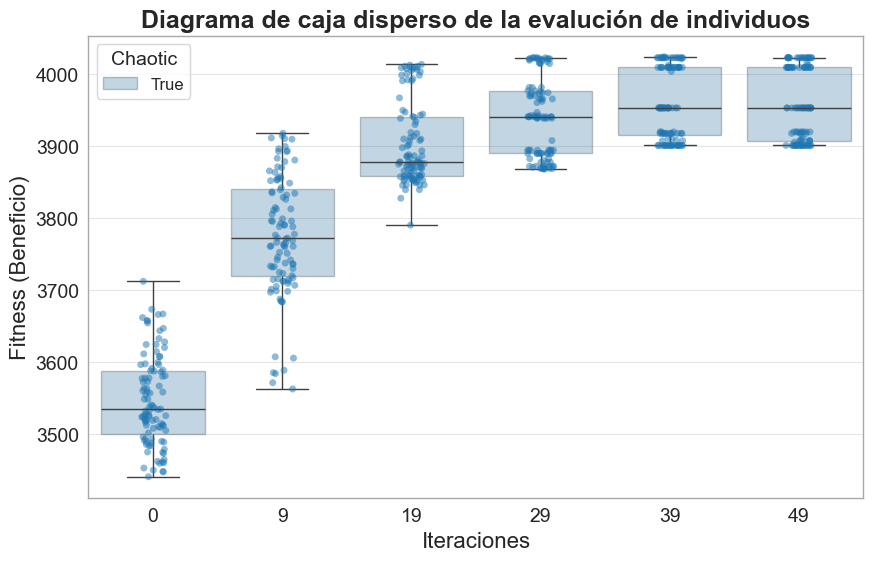

In [16]:
# Filter df, only rows with 'Iteration' values included in [0, .., 49]
df_boxplot_filtered = df_boxplot[df_boxplot['Iteration'].isin([0, 9, 19, 29, 39, 49])]

sns_box_plot(df=df_boxplot_filtered,
             x_data='Iteration',
             y_data='Fitness',
             hue='Chaotic',
             title="Diagrama de caja disperso de la evalución de individuos",
             x_label="Iteraciones",
             y_label="Fitness (Beneficio)",
             save_path=Path('../reports/gsa/scattered_boxplot_25.pdf'))

In [17]:
df_gcc

,Run,Iteration,Fitness,Accuracy,ExecutionTime,Discrete,Real,chaotic_constant
0,1,0,3487.556783,0,0.094590,"[False, True, False, True, True, True, True, F...","[1054, 1103, 1141, 869, 968, 1042, 906, 834, 9...",True
1,1,1,3673.713002,0,0.371977,"[False, True, False, True, True, True, True, F...","[1061.0, 1109.0, 1143.0, 872.0, 973.0, 1049.0,...",True
2,1,2,3707.095889,0,0.647769,"[False, True, False, True, True, True, True, F...","[1060, 1112, 1143, 871, 971, 1048, 904, 821, 9...",True
3,1,3,3810.934696,0,0.950542,"[False, True, False, True, True, True, True, F...","[1059, 1110, 1146, 869, 967, 1049, 906, 828, 9...",True
4,1,4,3892.496799,0,1.226305,"[False, True, False, True, True, True, True, F...","[1061, 1109, 1144, 871, 969, 1049, 904, 826, 9...",True
...,...,...,...,...,...,...,...,...
45,5,45,3920.168404,0,11.471254,"[False, True, False, True, True, True, True, F...","[1064, 1115, 1147, 869, 971, 1047, 900, 827, 9...",True
46,5,46,3920.168404,0,11.716541,"[False, True, False, True, True, True, True, F...","[1064, 1115, 1147, 869, 971, 1047, 900, 827, 9...",True
47,5,47,3920.168404,0,11.978921,"[False, True, False, True, True, True, True, F...","[1064, 1115, 1147, 869, 971, 1047, 900, 827, 9...",True
48,5,48,3920.168404,0,12.222028,"[False, True, False, True, True, True, True, F...","[1064, 1115, 1147, 869, 971, 1047, 900, 827, 9...",True


In [18]:
# Table with results by run
service_tsps = {service.id: service.tsp.name for service in supply.services}
columns = ['Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
columns += set(service_tsps.values())

summary_df = pd.DataFrame(columns=columns)

df_train_chaotic = df_gcc[df_gcc['chaotic_constant'] == True]
run_grouped_df = df_train_chaotic.groupby('Run')

for group in run_grouped_df.groups:
    run = run_grouped_df.get_group(group)['Run'].iloc[-1]
    revenue = run_grouped_df.get_group(group)['Fitness'].iloc[-1]
    execution_time = run_grouped_df.get_group(group)['ExecutionTime'].iloc[-1]
    scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
    scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
    real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
    sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
    delta_dt = 0.0
    delta_tt = 0.0
    services_by_tsp = {tsp: 0 for tsp in service_tsps.values()}
    for i, service in enumerate(sm.requested_schedule):
        if not scheduled_trains_array[i]:
            continue
        departure_station = list(sm.requested_schedule[service].keys())[0]
        delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                        sm.requested_schedule[service][departure_station][1])
        for j, stop in enumerate(sm.requested_schedule[service].keys()):
            if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                continue
            delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])

        service_tsp = service_tsps[service]
        services_by_tsp[service_tsp] += 1

    percentages_by_tsp = {}
    for tsp in services_by_tsp:
        percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100,2)} %"
    row_data =  [run, revenue, execution_time, scheduled_trains, delta_dt, delta_tt, *list(percentages_by_tsp.values())]
    summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Revenue', ascending=False)
display(summary_df)

,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),RU1,RU4,RU3,RU2
0,1,4026.801327,12.619854,18,33.0,121.0,50.0 %,90.0 %,33.33 %,100.0 %
2,3,4009.826180,12.400134,18,33.0,115.0,50.0 %,90.0 %,33.33 %,100.0 %
1,2,3953.466642,12.473113,17,23.0,111.0,50.0 %,80.0 %,33.33 %,100.0 %
4,5,3920.168404,12.463515,17,28.0,102.0,50.0 %,80.0 %,33.33 %,100.0 %
3,4,3901.375666,12.433434,17,29.0,127.0,50.0 %,80.0 %,50.0 %,80.0 %


In [19]:
summary_df.to_latex()

'\\begin{tabular}{lrrrrrrllll}\n\\toprule\n & Run & Revenue & Execution Time (s.) & Scheduled Trains & Delta DT (min.) & Delta TT (min.) & RU1 & RU4 & RU3 & RU2 \\\\\n\\midrule\n0 & 1 & 4026.801327 & 12.619854 & 18 & 33.000000 & 121.000000 & 50.0 % & 90.0 % & 33.33 % & 100.0 % \\\\\n2 & 3 & 4009.826180 & 12.400134 & 18 & 33.000000 & 115.000000 & 50.0 % & 90.0 % & 33.33 % & 100.0 % \\\\\n1 & 2 & 3953.466642 & 12.473113 & 17 & 23.000000 & 111.000000 & 50.0 % & 80.0 % & 33.33 % & 100.0 % \\\\\n4 & 5 & 3920.168404 & 12.463515 & 17 & 28.000000 & 102.000000 & 50.0 % & 80.0 % & 33.33 % & 100.0 % \\\\\n3 & 4 & 3901.375666 & 12.433434 & 17 & 29.000000 & 127.000000 & 50.0 % & 80.0 % & 50.0 % & 80.0 % \\\\\n\\bottomrule\n\\end{tabular}\n'

In [19]:
def get_gsa_table_results(chaotic: bool = True) -> pd.DataFrame:
    service_tsps = {service.id: service.tsp.name for service in supply.services}
    columns = ['Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
    columns += set(service_tsps.values())
    
    summary_df = pd.DataFrame(columns=columns)
    
    df_train_chaotic = df_gcc[df_gcc['chaotic_constant'] == chaotic]
    run_grouped_df = df_train_chaotic.groupby('Run')
    
    for group in run_grouped_df.groups:
        run = run_grouped_df.get_group(group)['Run'].iloc[-1]
        revenue = run_grouped_df.get_group(group)['Fitness'].iloc[-1]
        execution_time = run_grouped_df.get_group(group)['ExecutionTime'].iloc[-1]
        scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
        scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
        real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
        sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
        delta_dt = 0.0
        delta_tt = 0.0
        services_by_tsp = {tsp: 0 for tsp in service_tsps.values()}
        for i, service in enumerate(sm.requested_schedule):
            if not scheduled_trains_array[i]:
                continue
            departure_station = list(sm.requested_schedule[service].keys())[0]
            delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                            sm.requested_schedule[service][departure_station][1])
            for j, stop in enumerate(sm.requested_schedule[service].keys()):
                if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                    continue
                delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])
    
            service_tsp = service_tsps[service]
            services_by_tsp[service_tsp] += 1
    
        percentages_by_tsp = {}
        for tsp in services_by_tsp:
            percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100,2)} %"
        row_data =  [run, revenue, execution_time, scheduled_trains, delta_dt, delta_tt, *list(percentages_by_tsp.values())]
        summary_df.loc[len(summary_df)] = row_data
    
    return summary_df.sort_values('Revenue', ascending=False)

summary_df_nc = get_gsa_table_results(chaotic=False)
display(summary_df_nc)

,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),RU4,RU1,RU2,RU3
5,6,3043.865778,7.289598,12,15.0,90.0,50.0 %,50.0 %,50.0 %,40.0 %
9,10,3021.271733,7.329283,12,23.0,84.0,50.0 %,60.0 %,33.33 %,40.0 %
3,4,3009.600338,7.299977,12,16.0,104.0,50.0 %,60.0 %,33.33 %,40.0 %
10,11,3002.277110,7.325142,12,17.0,106.0,50.0 %,50.0 %,50.0 %,40.0 %
6,7,2988.553536,7.444431,12,24.0,87.0,50.0 %,50.0 %,50.0 %,40.0 %
1,2,2981.581327,7.310717,12,25.0,85.0,50.0 %,60.0 %,33.33 %,40.0 %
2,3,2978.112348,7.213606,12,37.0,101.0,50.0 %,60.0 %,33.33 %,40.0 %
0,1,2970.847265,7.510232,12,20.0,106.0,50.0 %,60.0 %,33.33 %,40.0 %
8,9,2969.936666,7.544589,12,22.0,104.0,50.0 %,60.0 %,33.33 %,40.0 %
4,5,2966.055081,7.319390,11,22.0,89.0,50.0 %,50.0 %,33.33 %,40.0 %


In [20]:
summary_df_nc.to_latex()

'\\begin{tabular}{lrrrrrrllll}\n\\toprule\n & Run & Revenue & Execution Time (s.) & Scheduled Trains & Delta DT (min.) & Delta TT (min.) & RU4 & RU1 & RU2 & RU3 \\\\\n\\midrule\n5 & 6 & 3043.865778 & 7.289598 & 12 & 15.000000 & 90.000000 & 50.0 % & 50.0 % & 50.0 % & 40.0 % \\\\\n9 & 10 & 3021.271733 & 7.329283 & 12 & 23.000000 & 84.000000 & 50.0 % & 60.0 % & 33.33 % & 40.0 % \\\\\n3 & 4 & 3009.600338 & 7.299977 & 12 & 16.000000 & 104.000000 & 50.0 % & 60.0 % & 33.33 % & 40.0 % \\\\\n10 & 11 & 3002.277110 & 7.325142 & 12 & 17.000000 & 106.000000 & 50.0 % & 50.0 % & 50.0 % & 40.0 % \\\\\n6 & 7 & 2988.553536 & 7.444431 & 12 & 24.000000 & 87.000000 & 50.0 % & 50.0 % & 50.0 % & 40.0 % \\\\\n1 & 2 & 2981.581327 & 7.310717 & 12 & 25.000000 & 85.000000 & 50.0 % & 60.0 % & 33.33 % & 40.0 % \\\\\n2 & 3 & 2978.112348 & 7.213606 & 12 & 37.000000 & 101.000000 & 50.0 % & 60.0 % & 33.33 % & 40.0 % \\\\\n0 & 1 & 2970.847265 & 7.510232 & 12 & 20.000000 & 106.000000 & 50.0 % & 60.0 % & 33.33 % & 40.0 % 

In [20]:
# Global status

def get_gsa_global_status(df: pd.DataFrame):
    run_grouped_df = df.groupby('Run')
    print("Global GSA status:")
    
    # Execution time (mean and std.)
    run_times = run_grouped_df['ExecutionTime'].last()
    print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
    print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')
    
    # Revenue (mean and std.)
    run_revenues = run_grouped_df['Fitness'].last()
    print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')
    
    # Scheduled trains (mean and std.)
    run_trains = run_grouped_df['Discrete'].last().apply(sum)
    print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')
    
    runs_best_solution_history = dict(sorted(rbs_hist[True].items(),
                                             key=lambda x: x[1][1]))
    
    q2_solution_index = np.floor(runs // 2).astype(int)
    gsa_solution = tuple(runs_best_solution_history.items())[q2_solution_index]
    
    print(f"\tMedian solution: Run {gsa_solution[0]}")
    max_revenue = sum([sm.revenue[service]['canon'] for service in sm.revenue])
    print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")
    
    return gsa_solution

df_train_chaotic = df_gcc[df_gcc['chaotic_constant'] == True]
gsa_solution = get_gsa_global_status(df_train_chaotic)

Global GSA status:
	Total execution time: 62.3901 s.
	Execution Time (by run) - Mean: 12.478 s. - Std: 0.0843 s.
	Revenue - Mean: 3962.3276 - Std: 54.7358
	Scheduled Trains - Mean: 17.0 - Std: 1.0
	Median solution: Run 2
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible


In [22]:
df_train_nc = df_gcc[df_gcc['chaotic_constant'] == False]
_ = get_gsa_global_status(df_train_nc)

Global GSA status:
	Total execution time: 81.2906 s.
	Execution Time (by run) - Mean: 7.3901 s. - Std: 0.1443 s.
	Revenue - Mean: 2990.3014 - Std: 26.0748
	Scheduled Trains - Mean: 12.0 - Std: 0.0
	Median solution: Run 5
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible


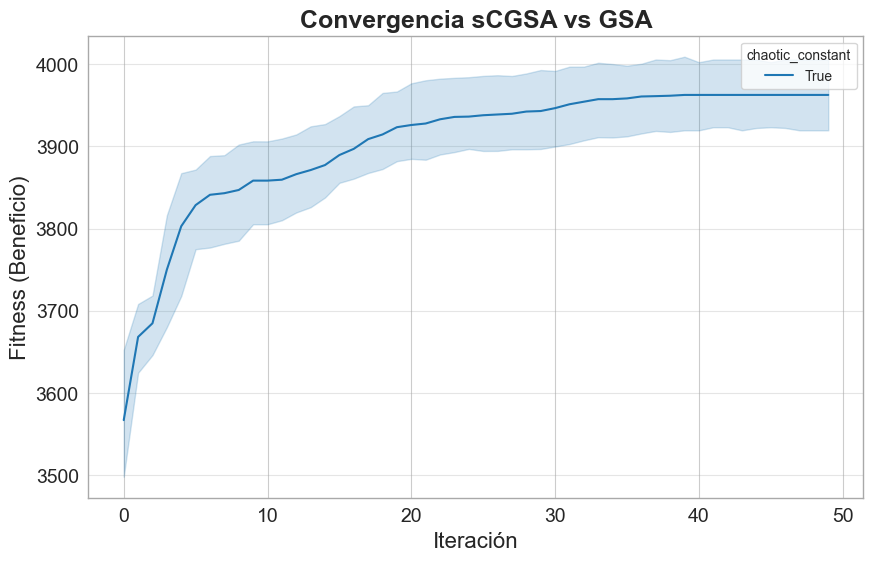

In [21]:
# GSA Convergence plot
sns_line_plot(df=df_gcc,
              x_data="Iteration",
              y_data="Fitness",
              hue="chaotic_constant",
              title="Convergencia sCGSA vs GSA",
              x_label="Iteración",
              y_label="Fitness (Beneficio)",
              save_path=Path('../reports/gsa/gsa_convergence_25.pdf'))

In [22]:
from scipy import stats

fitness_sCGSA = summary_df['Revenue'].values
fitness_GSA = summary_df_nc['Revenue'].values

fitness_sCGSA, fitness_GSA

NameError: name 'summary_df_nc' is not defined

In [25]:
stat, p_value = stats.wilcoxon(fitness_sCGSA, fitness_GSA)
print(f"Estadístico de Wilcoxon: {stat}, Valor p: {p_value}")

Estadístico de Wilcoxon: 1.0, Valor p: 0.001953125


In [23]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

services = sm.update_supply(path=generator_save_path,
                            solution=gsa_solution[1][0])

sm.update_schedule(solution=gsa_solution[1][0])

filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if gsa_solution[1][0].discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

#plotter = TrainSchedulePlotter(filtered_services, line)
#plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_gsa'
print(supply_save_path, tt_file_name)
SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)

# Copy previous file in reports
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'gsa/{tt_file_name}_25_new.yml')

supply_config_file = Path(f'{supply_save_path}{tt_file_name}.yml')

../configs/gsa_results/ supply_config_gsa


In [24]:
final_supply = Supply.from_yaml(supply_config_file)

{'1_2024-06-25-14.32': {'Madrid': [869.0, 869.0], 'Zaragoza': [966.0, 971.0], 'Tarragona': [1043.0, 1046.0], 'Barcelona': [1096.0, 1096.0]}, '3_2024-06-25-13.47': {'Madrid': [827.0, 827.0], 'Zaragoza': [911.0, 912.0], 'Barcelona': [1012.0, 1012.0]}, '4_2024-06-25-22.34': {'Madrid': [1354.0, 1354.0], 'Barcelona': [1522.0, 1522.0]}, '5_2024-06-25-12.09': {'Lleida': [732.0, 732.0], 'Barcelona': [803.0, 803.0]}, '6_2024-06-25-2.10': {'Madrid': [126.0, 126.0], 'Zaragoza': [205.0, 211.0], 'Tarragona': [270.0, 277.0], 'Barcelona': [317.0, 317.0]}, '8_2024-06-25-8.51': {'Madrid': [530.0, 530.0], 'Zaragoza': [628.0, 631.0], 'Lleida': [690.0, 693.0], 'Barcelona': [782.0, 782.0]}, '10_2024-06-25-12.28': {'Madrid': [748.0, 748.0], 'Barcelona': [923.0, 923.0]}, '12_2024-06-25-6.38': {'Zaragoza': [399.0, 399.0], 'Lleida': [460.0, 464.0], 'Tarragona': [504.0, 507.0], 'Barcelona': [558.0, 558.0]}, '13_2024-06-25-15.39': {'Madrid': [939.0, 939.0], 'Guadalajara': [967.0, 968.0], 'Zaragoza': [1037.0, 104

/Users/david/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


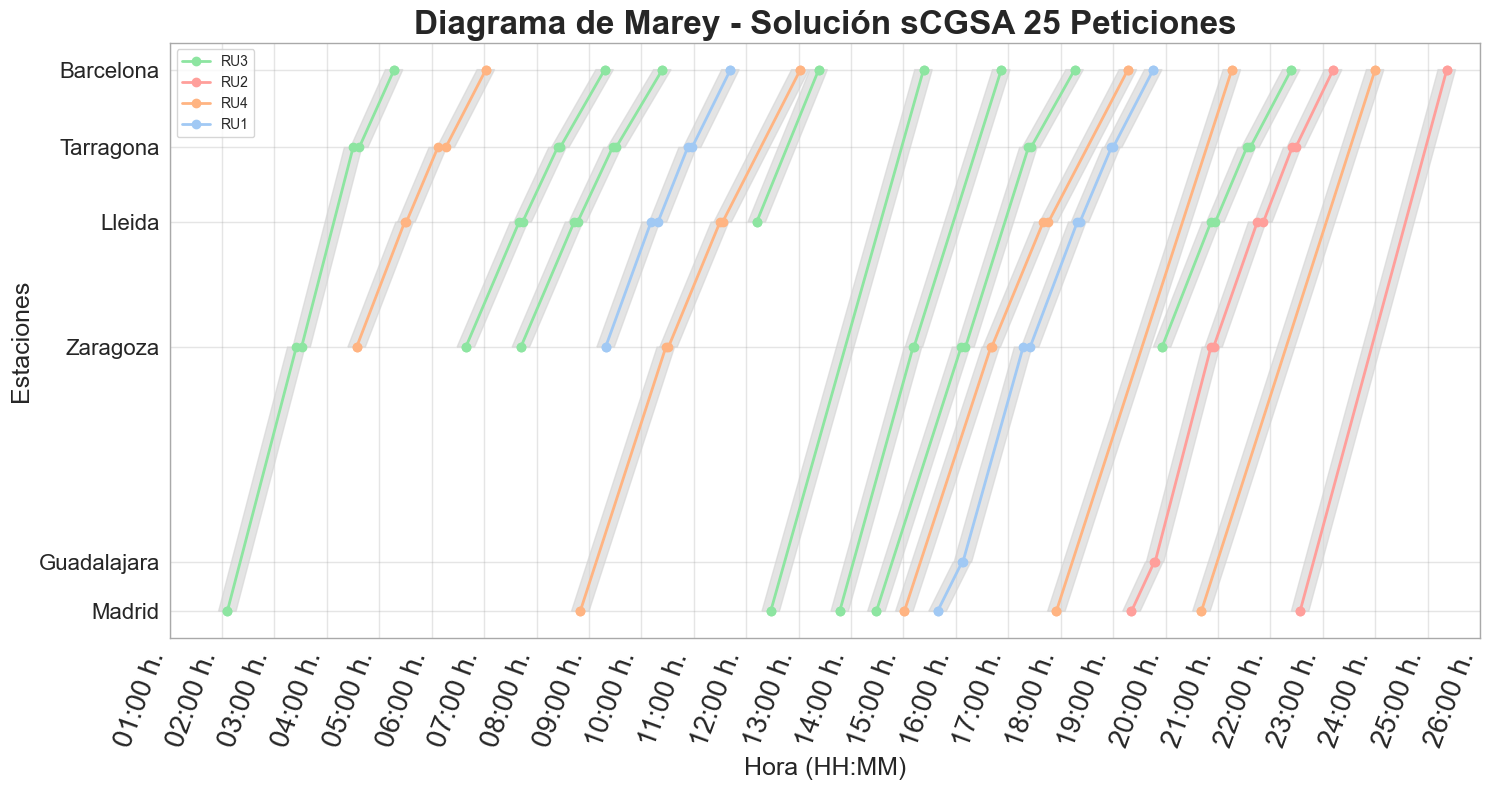

In [25]:
plot_marey_chart(requested_supply=final_supply,
                 colors_by_tsp=True, 
                 main_title="Diagrama de Marey - Solución sCGSA 25 Peticiones",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/gsa/marey_chart_sol_25.pdf'))

In [29]:
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'gsa/{tt_file_name}_25.yml')

PosixPath('../reports/gsa/supply_config_gsa_25.yml')

In [30]:
#!snakeviz profile.pstat